# Customer: Caleb

Detecting camera in image 
binary classification using fine tuning of pretrained models

### Check tensorflow runs on GPU 

source: [run Keras model on gpu](https://stackoverflow.com/questions/45662253/can-i-run-keras-model-on-gpu)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10787503637787690327
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 335263401690581853
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16970200193337384598
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7462076416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1525422132626650508
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Load the pre-trained model

VGG model


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import os 

In [13]:
train_dir = './data/content/train'
validation_dir = './data/content/validation'
image_size = 224

In [14]:
from keras.applications import VGG16
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

## Freeze the required layers


In [15]:

# for layer in vgg_conv.layers: # let's freeze all conv layers 

for layer in vgg_conv.layers[:-4]: 
# for layer in vgg_conv.layers: 
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc3b4700b38> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b4707400> False
<keras.layers.convolutional.Conv2D object at 0x7fc3dc20f7b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc3b45bd7f0> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b45bdba8> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b459b390> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc3b45b8b70> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b45b8ef0> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b4568a20> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b45025c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc3b4535358> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b4535a90> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b44d1e10> False
<keras.layers.convolutional.Conv2D object at 0x7fc3b44835f8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc3b44b4470>

## Create a new model


In [16]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


## Prepare data


In [17]:
# from bs4 import BeautifulSoup
import numpy as np
# import requests
# import cv2
# import PIL.Image
# import urllib
import os

In [18]:
def create_dir(path_dir):    
    '''
    path_dir - str e.g. "./content/train/ships"
    '''    
    path_steps=  path_dir.split('/')
    for l in range (1,len(path_steps)):
        parent_dir = '/'.join(path_steps[:l+1])
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)  
    
# create_dir("./test/content/train/ships/test/test")

def create_all_dirs(target_classes):
    for c in target_classes:
        create_dir('./data/content/train/{}'.format(c))
        create_dir('./data/content/validation/{}'.format(c))
# create_all_dirs(target_classes)

## Split to train and validation datasets


In [21]:
import os
import shutil
from tqdm import tqdm
# src_files = os.listdir(src)
# for file_name in src_files:
#     full_file_name = os.path.join(src, file_name)
#     if (os.path.isfile(full_file_name)):
#         shutil.copy(full_file_name, dest)

In [22]:
# src  = 'many-faces'
# f= 'single-or-no/00001200.jpg'
# dest = './content/train/negative'
# os.path.join(src,f)

# shutil.copy(os.path.join(src,f), dest)

# f= 'many-faces/single-or-no/00000299.jpg'
# shutil.copy(f, dest)

### Uncomment 2 last lines to copy the data again to target structure 

In [25]:

target_classes= {
    'positive': '',
    'negative': '',    
}
create_all_dirs(target_classes)

np.random.seed(0)


def train_test_split(src, dest):
    '''
    src e.g. 'many-faces/many-faces'
    dest e.g. 'negative'
    '''
    src_files = os.listdir(src)
    all_files = [file_name for file_name in src_files]
    n_train= int(len(all_files)*.9)
    np.random.shuffle(all_files)
    full_dest =  './data/content/train/{}'.format(dest)
    for f in tqdm(all_files[:n_train]):
        shutil.copy(os.path.join(src,f), full_dest)
    full_dest =  './data/content/validation/{}'.format(dest)
    for f in tqdm(all_files[n_train:]):
        shutil.copy(os.path.join(src,f), full_dest)    
    print ('Complited copy:\n{:,} train {}\n {:,} validation {}'.format (n_train,dest,len(all_files[n_train:]),dest))

#     data/count-faces/many-faces
src_pos  = 'data/count-faces/many-faces/many'
src_neg = 'data/count-faces/many-faces/single'

# train_test_split(src= src_neg, dest= 'negative')
# train_test_split(src= src_pos, dest= 'positive')           



100%|██████████| 60/60 [00:00<00:00, 4544.95it/s]

Complited copy:
631 train negative
 71 validation negative
Complited copy:
531 train positive
 60 validation positive


## Setup the data generators


In [26]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1161 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


## Train the model


In [30]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
# NOTE that we have multiplied the steps_per_epoch by 2. This is because we are using data augmentation.

history = model.fit_generator(
      train_generator,
      steps_per_epoch=2*train_generator.samples/train_generator.batch_size ,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
  
# Save the model
model.save('caleb_multi_faces_last4.h5')

Epoch 1/15
47/46 [==============================] - 58s 1s/step - loss: 0.1337 - acc: 0.9757 - val_loss: 0.1542 - val_acc: 0.9462
Epoch 2/15
47/46 [==============================] - 55s 1s/step - loss: 0.1126 - acc: 0.9851 - val_loss: 0.1738 - val_acc: 0.9462
Epoch 3/15
47/46 [==============================] - 63s 1s/step - loss: 0.0723 - acc: 0.9872 - val_loss: 0.1870 - val_acc: 0.9462
Epoch 4/15
47/46 [==============================] - 57s 1s/step - loss: 0.0288 - acc: 0.9902 - val_loss: 0.1962 - val_acc: 0.9615
Epoch 5/15
47/46 [==============================] - 55s 1s/step - loss: 0.0835 - acc: 0.9832 - val_loss: 0.2110 - val_acc: 0.9615
Epoch 6/15
47/46 [==============================] - 52s 1s/step - loss: 0.0293 - acc: 0.9915 - val_loss: 0.1563 - val_acc: 0.9538
Epoch 7/15
47/46 [==============================] - 55s 1s/step - loss: 0.0625 - acc: 0.9885 - val_loss: 0.1358 - val_acc: 0.9615
Epoch 8/15
47/46 [==============================] - 55s 1s/step - loss: 0.1194 - acc: 0.98

In [32]:
# reduce lr
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-6),
              metrics=['acc'])
# Train the model
# NOTE that we have multiplied the steps_per_epoch by 2. This is because we are using data augmentation.

history = model.fit_generator(
      train_generator,
      steps_per_epoch=2*train_generator.samples/train_generator.batch_size ,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
  
# Save the model
model.save('caleb_multi_faces_last4_low_lr.h5')

Epoch 1/15
47/46 [==============================] - 55s 1s/step - loss: 0.0195 - acc: 0.9928 - val_loss: 0.1189 - val_acc: 0.9692
Epoch 2/15
47/46 [==============================] - 55s 1s/step - loss: 0.0105 - acc: 0.9970 - val_loss: 0.1206 - val_acc: 0.9769
Epoch 3/15
47/46 [==============================] - 56s 1s/step - loss: 0.0210 - acc: 0.9953 - val_loss: 0.1259 - val_acc: 0.9692
Epoch 4/15
47/46 [==============================] - 54s 1s/step - loss: 0.0074 - acc: 0.9983 - val_loss: 0.1359 - val_acc: 0.9692
Epoch 5/15
47/46 [==============================] - 54s 1s/step - loss: 0.0111 - acc: 0.9970 - val_loss: 0.1427 - val_acc: 0.9692
Epoch 6/15
47/46 [==============================] - 54s 1s/step - loss: 0.0068 - acc: 0.9979 - val_loss: 0.1394 - val_acc: 0.9692
Epoch 7/15
47/46 [==============================] - 53s 1s/step - loss: 0.0073 - acc: 0.9983 - val_loss: 0.1478 - val_acc: 0.9692
Epoch 8/15
47/46 [==============================] - 57s 1s/step - loss: 0.0032 - acc: 0.99

## Review performance


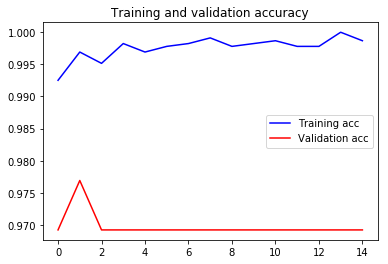

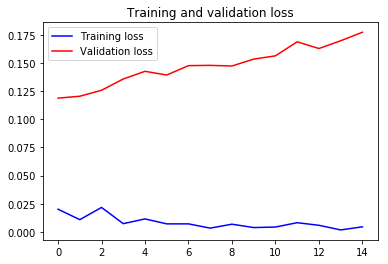

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Review wrong predicted images


Found 130 images belonging to 2 classes.
13/13 [==============================] - 2s 132ms/step
Errors amount = 4/130


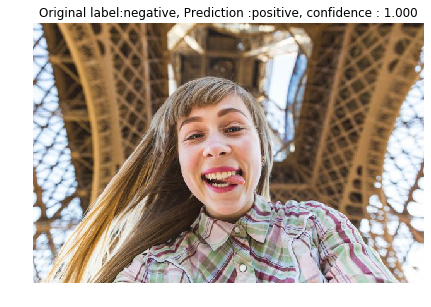

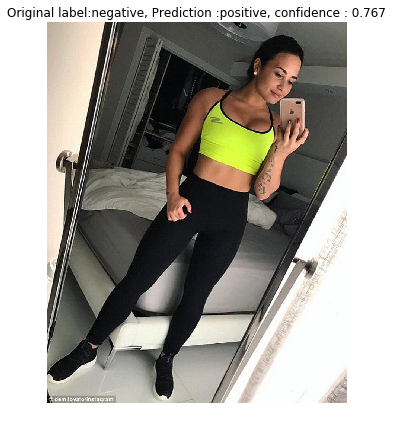

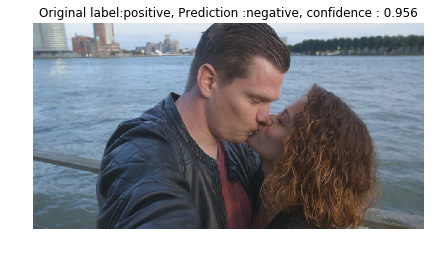

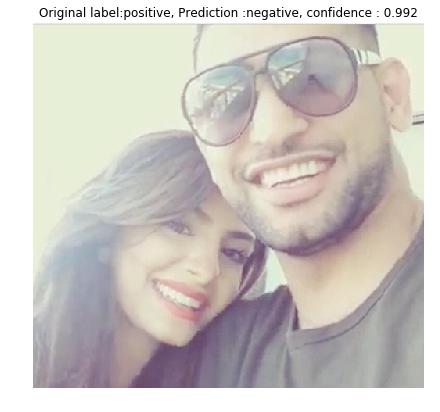

In [34]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("Errors amount = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()